In [2]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
from psiam_tied_dv_map_utils import psiam_tied_data_gen_wrapper_V_A_change, psiam_tied_data_gen_wrapper_V_A_change_no_L
import pandas as pd
import random

# Params

In [3]:
# V_A = 1.6
# theta_A = 2.53
V_A = 1.6
theta_A = 2.53

rate_lambda = 0.118
T_0 = 1/2220
theta_E = 45

t_A_aff = -0.187
t_E_aff = 0.075

Z_E = 0

N_sim = int(500e3)
dt = 1e-4

# ABL, ILD, stim and led times from data

In [6]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# simulate

In [7]:
# sample N_sim tuples for t_stim_and_led_tuple
np.random.seed(42)
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim)
t_stim_and_led_tuple = [t_stim_and_led_tuple[i] for i in sampled_indices]

In [5]:
is_LED_trial = True
new_V_A = V_A + 1.8
N_print = int(N_sim/5)
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V_A_change_no_L)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff,\
                                                                                    t_stim_and_led_tuple[iter_num], new_V_A, iter_num, N_print, is_LED_trial, dt) for iter_num in range(N_sim))


os id: 1810641, In iter_num: 0, ABL: 40, ILD: 4.0, t_stim: 0.479616722682289
os id: 1810696, In iter_num: 100000, ABL: 60, ILD: -8.0, t_stim: 0.555807335374456
os id: 1810697, In iter_num: 200000, ABL: 20, ILD: 4.0, t_stim: 0.448242219501018
os id: 1810691, In iter_num: 300000, ABL: 40, ILD: -16.0, t_stim: 0.215454052807544
os id: 1810650, In iter_num: 400000, ABL: 20, ILD: -1.0, t_stim: 0.552525528797533


In [6]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df['correct'] = (sim_results_df['ILD'] * sim_results_df['choice']).apply(lambda x: 1 if x > 0 else 0)

# RTD

In [8]:
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

df_led_off = df[df['LED_trial'] == 0]
df_led_on = df[df['LED_trial'] == 1]

In [8]:
# data
df_led_on_small_aborts_cleaned = df_led_on[ ~((df_led_on['timed_fix'] < df_led_on['intended_fix']) & (df_led_on['timed_fix'] < 0.3)) ]

led_on_rt_wrt_stim = df_led_on_small_aborts_cleaned['timed_fix'] - df_led_on_small_aborts_cleaned['intended_fix']

# sim
sim_results_df_cleaned = sim_results_df[ ~((sim_results_df['rt'] < sim_results_df['t_stim']) & (sim_results_df['rt'] < 0.3)) ]
sim_rt_wrt_stim = sim_results_df_cleaned['rt'] - sim_results_df_cleaned['t_stim']

Text(0, 0.5, 'density')

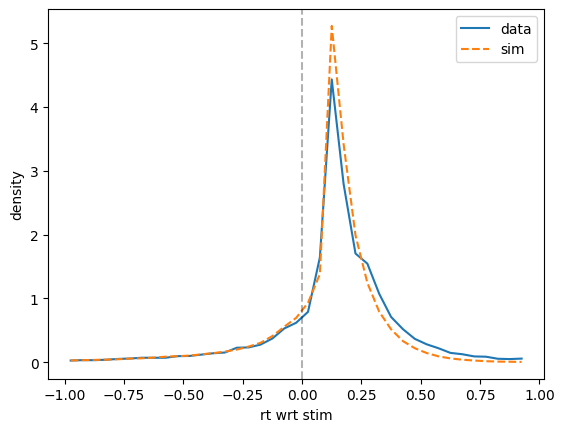

In [9]:
bins = np.arange(-1,1,0.05)
bin_centers = (bins[1:] + bins[:-1])/2

data_hist, _ = np.histogram(led_on_rt_wrt_stim, bins=bins, density=True)
sim_hist, _ = np.histogram(sim_rt_wrt_stim, bins=bins, density=True)


plt.plot(bin_centers, data_hist, label='data')
plt.plot(bin_centers, sim_hist, label='sim', ls='--')
plt.axvline(0, color='k', ls='--', alpha=0.3)
plt.legend()
plt.xlabel('rt wrt stim')
plt.ylabel('density')

# diagnostics

In [15]:
data_df = df_led_on_small_aborts_cleaned.copy()
sim_df = sim_results_df_cleaned.copy()

# remove rt - t_stim > 1s
data_df = data_df[ data_df['timed_fix'] - data_df['intended_fix'] < 1 ]
sim_df = sim_df[ sim_df['rt'] - sim_df['t_stim'] < 1 ]

In [16]:
# rename columns in data_df
data_df = data_df.rename(columns={'timed_fix': 'rt', 'intended_fix': 't_stim'})

In [17]:
from diagnostics_class import Diagnostics

sim_diagnose_obj = Diagnostics(sim_df)
data_diagnose_obj = Diagnostics(data_df)

# remove aborts
data_df_valid = data_df[ data_df['rt'] > data_df['t_stim'] ]
sim_df_valid = sim_df[ sim_df['rt'] > sim_df['t_stim'] ]

sim_diagnose_obj_valid = Diagnostics(sim_df_valid)
data_diagnose_obj_valid = Diagnostics(data_df_valid)

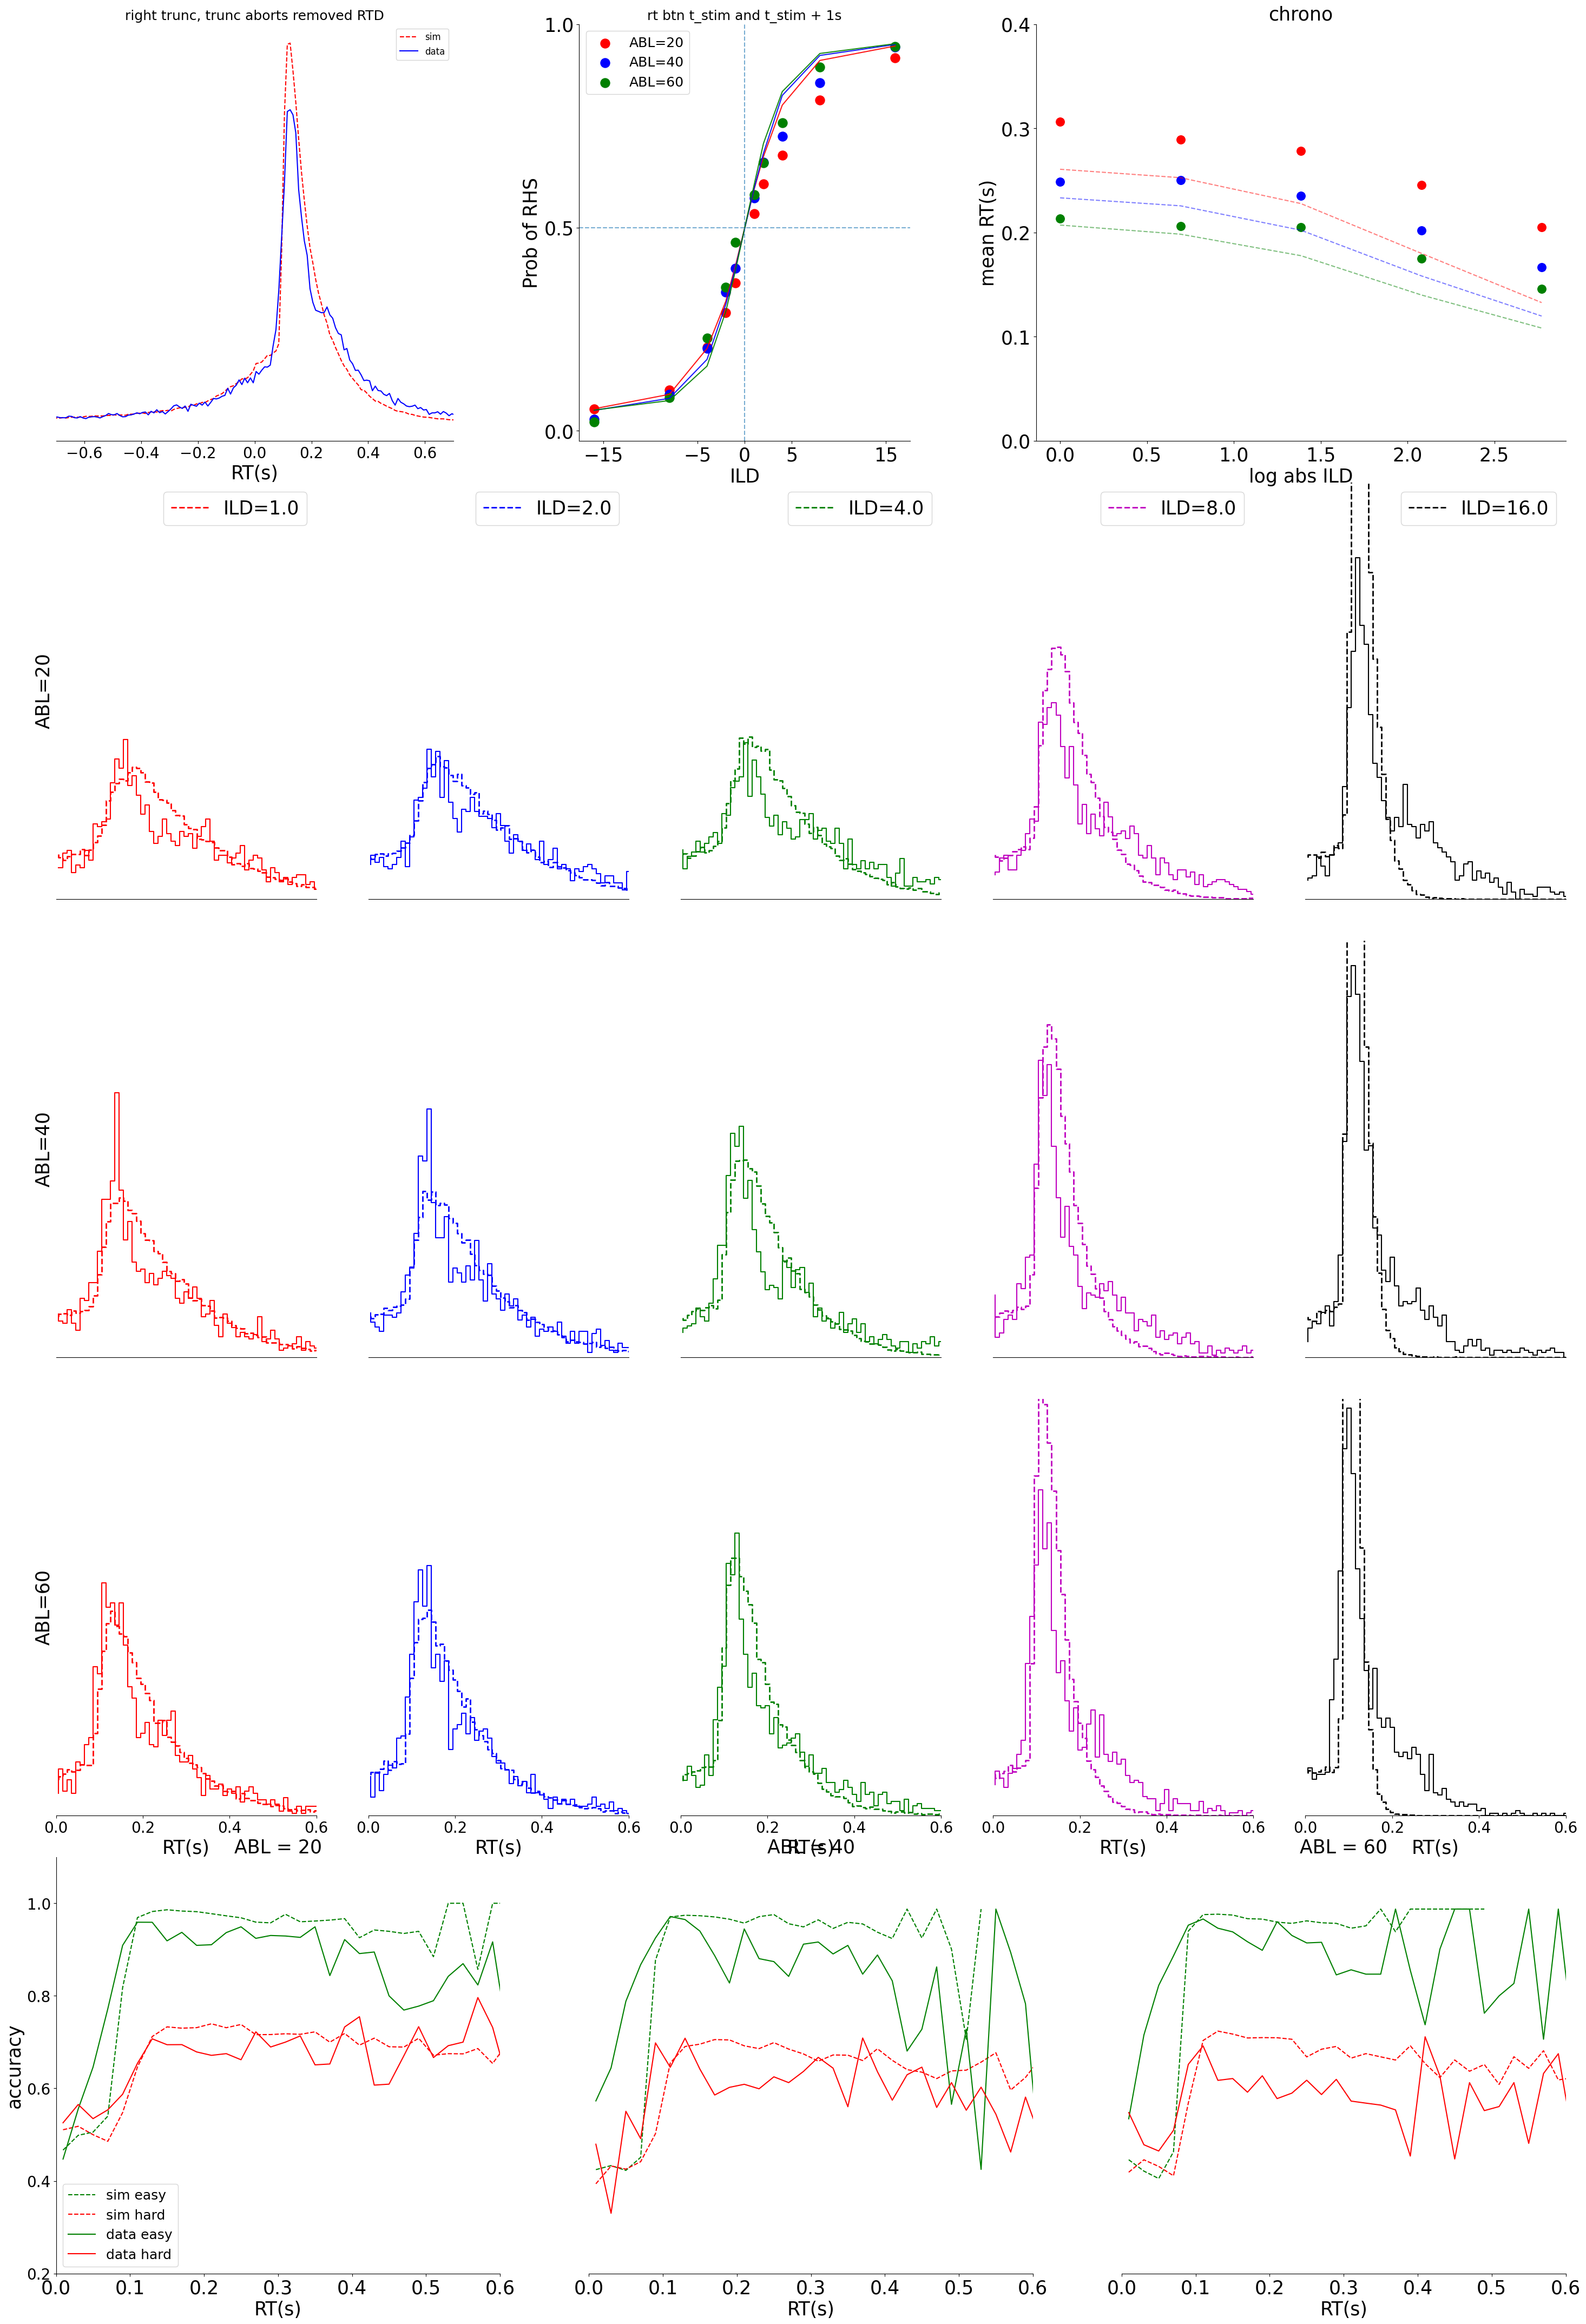

In [18]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1)

# --- 1) Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
    # subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    # wspace=0.09
)

# --- 2) Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

# 0 -grand RTD
bins = np.arange(-1, 1, 0.01)
x, y = sim_diagnose_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diagnose_obj.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-0.7, 0.7)

# 1 - psycho 
data_psycho = data_diagnose_obj_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
sim_psycho = sim_diagnose_obj_valid.plot_psycho()
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])
ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob of RHS', fontsize=25)
ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.set_xticks([-15, -5, 0, 5, 15])
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0, 0.5, 1.0])
ax_psy.axvline(0, linestyle='--', alpha=0.6)
ax_psy.axhline(0.5, linestyle='--', alpha=0.6)




# 2  - chrono
x, sim_chrono = sim_diagnose_obj_valid.plot_chrono()
for ABL in sim_chrono.keys():
    ax_chrono.plot(np.log(x), sim_chrono[ABL], color=ABL_colors[ABL], alpha=0.5, ls='--')

x, data_chrono = data_diagnose_obj_valid.plot_chrono()
for ABL in data_chrono.keys():
    ax_chrono.scatter(np.log(x), data_chrono[ABL], label=f'data ABL={ABL}', color=ABL_colors[ABL], marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel('log abs ILD', fontsize=25)
ax_chrono.set_ylabel('mean RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.set_ylim(0, 0.4)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_yticks(np.arange(0, 0.5, 0.1))

# RTDs per ABL
pos_ILD = all_ILD[all_ILD > 0]
bins = np.arange(0, 1, 0.01)
row = 0

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    ABL = ABL_arr[a]
    for j, ILD in enumerate(pos_ILD):
        ax = fig.add_subplot(gs[row, j])  

        sim_pd = sim_df_valid[(sim_df_valid['ABL'] == ABL) & (sim_df_valid['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']

        data_pd = data_df_valid[ (data_df_valid['ABL'] == ABL) & (data_df_valid['ILD'].isin([ILD, -ILD]))]
        data_rt = data_pd['rt'] - data_pd['t_stim']

        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
        t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
        ax.step(t_pts,sim_rt_hist, linestyle='dashed', color=ILD_colors[ILD], label='sim', linewidth=2)

        data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
        ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color=ILD_colors[ILD])

        if a == len(ABL_arr) - 1:
            ax.set_xlabel('RT(s)', fontsize=25)
        if j == 0:
            ax.set_ylabel(f'ABL={ABL}', fontsize=25)
            ax.tick_params(axis='y', which='major', labelsize=20)
        
        if a == 0:
            ax.legend([f'ILD={ILD}'], fontsize=25)

        # ax.legend(fontsize=18) # title covers it
        ax.set_xlim(0, 0.6)
        ax.set_ylim(0, 11)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(True)

        if j != 0:
            ax.spines['left'].set_visible(False)
        ax.set_yticks([])

        if a == len(ABL_arr) - 1:
            ax.tick_params(axis='both', which='major', labelsize=20)
        else:
            ax.set_xticks([])
    
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
bins = np.arange(0, 1, 0.02)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_df_valid[(sim_df_valid['ABL'] == ABL) & (sim_df_valid['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_df_valid[(sim_df_valid['ABL'] == ABL) & (sim_df_valid['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = data_df_valid[ (data_df_valid['ABL'] == ABL) & (data_df_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = data_df_valid[ (data_df_valid['ABL'] == ABL) & (data_df_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)



# df led on psycho check - why asymmetric?

(0.0, 1.0)

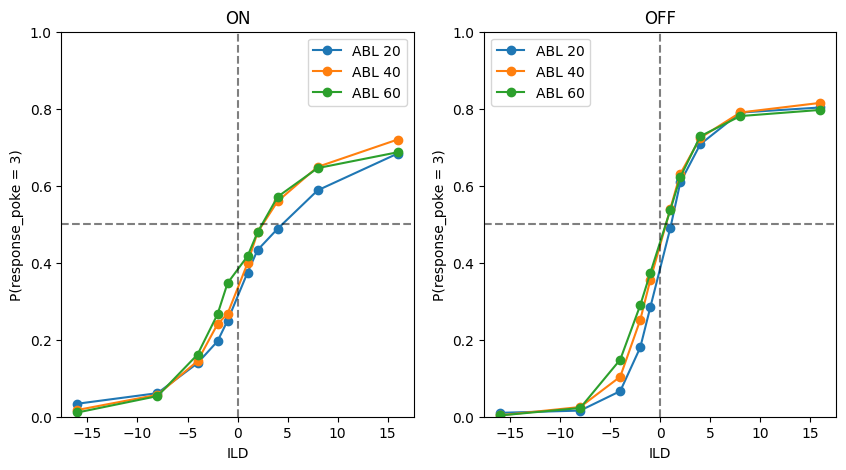

In [18]:
# Group by ILD and ABL, and calculate the probability of response_poke being 3
df_prob = df_led_on.groupby(['ABL', 'ILD'])['response_poke'].apply(lambda x: (x == 3).mean()).reset_index()

# Plot for each ABL
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
df_prob = df_led_on.groupby(['ABL', 'ILD'])['response_poke'].apply(lambda x: (x == 3).mean()).reset_index()

for abl in df_prob['ABL'].unique():
    subset = df_prob[df_prob['ABL'] == abl]
    plt.plot(subset['ILD'], subset['response_poke'], marker='o', linestyle='-', label=f'ABL {abl}')

plt.xlabel('ILD')
plt.ylabel('P(response_poke = 3)')
plt.title('ON')
plt.legend()

plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.ylim(0,1)

plt.subplot(1,2,2)
df_prob = df_led_off.groupby(['ABL', 'ILD'])['response_poke'].apply(lambda x: (x == 3).mean()).reset_index()

for abl in df_prob['ABL'].unique():
    subset = df_prob[df_prob['ABL'] == abl]
    plt.plot(subset['ILD'], subset['response_poke'], marker='o', linestyle='-', label=f'ABL {abl}')

plt.xlabel('ILD')
plt.ylabel('P(response_poke = 3)')
plt.title('OFF')
plt.legend()

plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.ylim(0,1)

# psychometrics for on and off

In [ ]:
for i in range(1, N_params):
    # for each V_A
    each_V_A_results = V_A_change_results_dict[i]['results']
    base_V_A =  V_A_change_results_dict[i]['V_A']
    new_V_A = V_A_change_results_dict[i]['new_V_A']

    num_up_on = {}; num_trials_on = {}
    num_up_off = {}; num_trials_off = {}
    for ABL in ABL_arr:
        num_up_on[ABL] = np.zeros_like(ILD_arr)
        num_trials_on[ABL] = np.zeros_like(ILD_arr)

        num_up_off[ABL] = np.zeros_like(ILD_arr)
        num_trials_off[ABL] = np.zeros_like(ILD_arr)

    
    for res in each_V_A_results:
        ABL = res['ABL']
        ILD = res['ILD']
        is_LED_trial = res['is_LED_trial']
        if is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        elif not is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

        

        

    plt.figure(figsize=(20,5))
    for a, ABL in enumerate(ABL_arr):
        plt.subplot(1, len(ABL_arr), a+1)
        plt.title(f'ABL={ABL},V_A={base_V_A}, new_V_A={new_V_A:.2f}')

        
        plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
        
        plt.legend()
        plt.xlabel('ILD'); plt.ylabel('P(up)');




# psychometric - designed

In [ ]:
i = 3
# for each V_A
each_V_A_results = V_A_change_results_dict[i]['results']
base_V_A =  V_A_change_results_dict[i]['V_A']
new_V_A = V_A_change_results_dict[i]['new_V_A']

num_up_on = {}; num_trials_on = {}
num_up_off = {}; num_trials_off = {}
for ABL in ABL_arr:
    num_up_on[ABL] = np.zeros_like(ILD_arr)
    num_trials_on[ABL] = np.zeros_like(ILD_arr)

    num_up_off[ABL] = np.zeros_like(ILD_arr)
    num_trials_off[ABL] = np.zeros_like(ILD_arr)


for res in each_V_A_results:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
            num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
            if res['choice'] == 1:
                num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
    elif not is_LED_trial:
        if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
            num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
            if res['choice'] == 1:
                num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

    


# average all LED off
led_off_psycho = np.zeros((len(ABL_arr), len(ILD_arr)))
for a, ABL in enumerate(ABL_arr):
    led_off_psycho[a] = num_up_off[ABL]/num_trials_off[ABL]
  

# take average of led_off_psycho across first dimension
led_off_psycho_avg = np.mean(led_off_psycho, axis=0)
plt.figure(figsize=(2.45,2.18))
# off
plt.scatter(ILD_arr, led_off_psycho_avg, color='k', marker='o', s=50)
plt.plot(ILD_arr, led_off_psycho_avg, color='k', lw=0.5)

# on
ABL_color_codes = {ABL_arr[0]: '#7D2E8C', ABL_arr[1]: '#75AB2E', ABL_arr[2]: '#D95219'}
# reverse ABL_arr
reverse_ABL_arr = ABL_arr[::-1]
for a,ABL in enumerate(reverse_ABL_arr):
    plt.scatter(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label=f'{ABL}', edgecolor=ABL_color_codes[ABL], marker='o', s=50, facecolors='white', lw=2)
    # plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], color=ABL_color_codes[ABL], lw=0.5)

plt.axhline(0.5, color='k', linestyle='dotted', lw=0.9)
plt.axvline(0, color='k', linestyle='dotted',lw=0.9)
plt.yticks([0, 0.5, 1], fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('ILD (dB)', fontsize=14)
# plt.title(f'only V_A change = {new_V_A:.2f}', fontsize=12)
plt.ylabel('P(R)', fontsize=14)

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.show()
# plt.savefig('h1_psycho.eps', format='eps', bbox_inches='tight')



# RT distributions

In [ ]:
base_V_A_data = V_A_change_results_dict[0]['results']

base_V_A_data_led_on = [res['rt'] - res['t_stim'] for res in base_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led']]
base_V_A_data_led_off = [res['rt'] - res['t_stim'] for res in base_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led']]

# change V_A
new_V_A_idx = 1
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']

new_V_A_data_led_on = [res['rt'] - res['t_stim'] for res in new_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led']]
new_V_A_data_led_off = [res['rt'] - res['t_stim'] for res in new_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led'] ]


In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(base_V_A_data_led_on, bins=np.arange(-2, 2, 0.05), density=True, label='no change ON', color='r', histtype='step')
plt.hist(new_V_A_data_led_on, bins=np.arange(-2, 2, 0.05), density=True, label=f'change to {new_V_A_value:.2f} ON', color='darkorange', histtype='step')
plt.title('LED on')
plt.xlabel('rt wrt stim'); plt.ylabel('density')
plt.legend()

plt.subplot(1,2,2)
plt.hist(base_V_A_data_led_off, bins=np.arange(-2, 2, 0.05), density=True, label='no change OFF', color='dimgray', histtype='step', lw=2)
plt.hist(new_V_A_data_led_off, bins=np.arange(-2, 2, 0.05), density=True, label=f'change to {new_V_A_value:.2f} OFF', color='royalblue', histtype='step')
plt.title('LED off')
plt.xlabel('rt wrt stim'); plt.ylabel('density')
plt.legend();

# Percentiles

In [ ]:
base_V_A_data = V_A_change_results_dict[0]['results']

base_V_A_data_led_on = [res['rt'] - res['t_stim'] for res in base_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led']]
base_V_A_data_led_off = [res['rt'] - res['t_stim'] for res in base_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led']]

# change V_A
new_V_A_idx = 9
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']

new_V_A_data_led_on = [res['rt'] - res['t_stim'] for res in new_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led']]
new_V_A_data_led_off = [res['rt'] - res['t_stim'] for res in new_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led'] ]


In [ ]:
base_on_abl_ild = {}
base_off_abl_ild = {}

new_on_abl_ild = {}
new_off_abl_ild = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        base_on_abl_ild[(ABL, int(ILD))] = []
        base_off_abl_ild[(ABL, int(ILD))] = []

        new_on_abl_ild[(ABL, int(ILD))] = []
        new_off_abl_ild[(ABL, int(ILD))] = []

for res in base_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            base_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            base_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])


for res in new_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            new_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            new_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])

In [ ]:
base_on_percentiles_dict = {}
base_off_percentiles_dict = {}

new_on_percentiles_dict = {}
new_off_percentiles_dict = {}

percentiles = [10, 30, 50, 70, 90]


for ABL in ABL_arr:
    base_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    base_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))

    new_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    new_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))


for ABL in ABL_arr:
    for ild_idx,ILD in enumerate(ILD_arr):
        for p, percentile in enumerate(percentiles):
            base_on_percentiles_dict[ABL][(p, ild_idx)] = np.percentile(base_on_abl_ild[ABL, int(ILD)], percentile)
            base_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(base_off_abl_ild[ABL, int(ILD)], percentile)

            new_on_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_on_abl_ild[ABL, int(ILD)], percentile)
            new_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_off_abl_ild[ABL, int(ILD)], percentile)

In [ ]:
# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},V_A={base_V_A}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, base_on_percentiles_dict[ABL][p], label=f'base ON {percentile}', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, base_off_percentiles_dict[ABL][p], label=f'base OFF {percentile}', linestyle='--', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('P(up)');

In [ ]:


# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},V_A={base_V_A}, new_V_A={new_V_A_value:.2f}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, new_on_percentiles_dict[ABL][p], label=f'new ON {percentile}', linestyle='-', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, new_off_percentiles_dict[ABL][p], label=f'new OFF {percentile}', linestyle='-', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('P(up)');

# PSTH of rt

In [ ]:
base_V_A_data = V_A_change_results_dict[0]['results']


# change V_A
new_V_A_idx = 4
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']


t_min = -0.1; t_max = 5; t_bin = 0.05
t_pts = np.arange(t_min, t_max, t_bin)

base_on_wrt_led = np.zeros_like(t_pts)
base_off_wrt_led = np.zeros_like(t_pts)

new_on_wrt_led = np.zeros_like(t_pts)
new_off_wrt_led = np.zeros_like(t_pts)

# base
for res in base_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_on_wrt_led):
                base_on_wrt_led[idx] += 1
            else:
                print(f'base on: {idx}')
    else:
        if res['rt'] > res['t_led']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_off_wrt_led):
                base_off_wrt_led[idx] += 1
            else:
                print(f'base off: {idx}')


base_on_wrt_led_prob = base_on_wrt_led / (np.sum(base_on_wrt_led)*t_bin)
base_off_wrt_led_prob = base_off_wrt_led / (np.sum(base_off_wrt_led)*t_bin)


# new
for res in new_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_on_wrt_led):
                new_on_wrt_led[idx] += 1
            else:
                print(f'new on: {idx}')
    else:
        if res['rt'] > res['t_led']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_off_wrt_led):
                new_off_wrt_led[idx] += 1
            else:
                print(f'new off: {idx}')

new_on_wrt_led_prob = new_on_wrt_led / (np.sum(new_on_wrt_led)*t_bin)
new_off_wrt_led_prob = new_off_wrt_led / (np.sum(new_off_wrt_led)*t_bin)

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(t_pts, base_on_wrt_led_prob, label='base ON', color='r', lw=3)
plt.plot(t_pts, base_off_wrt_led_prob, label='base OFF', color='b', lw=3)
plt.title('No change in V_A')
plt.xlabel('rt wrt led')
plt.ylabel('density')
plt.legend()


plt.subplot(1,2,2)
plt.plot(t_pts, new_on_wrt_led_prob, label='new ON', color='darkorange', lw=3)
plt.plot(t_pts, new_off_wrt_led_prob, label='new OFF', color='royalblue', lw=3)
plt.title(f'Change to {new_V_A_value:.2f}')
plt.xlabel('rt wrt led')
plt.legend()


# psth of abort

In [ ]:
base_V_A_data = V_A_change_results_dict[0]['results']


# change V_A
new_V_A_idx = 6
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']


t_min = -0.1; t_max = 5; t_bin = 0.05
t_pts = np.arange(t_min, t_max, t_bin)

base_on_wrt_led = np.zeros_like(t_pts)
base_off_wrt_led = np.zeros_like(t_pts)

new_on_wrt_led = np.zeros_like(t_pts)
new_off_wrt_led = np.zeros_like(t_pts)

# base
for res in base_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_on_wrt_led):
                base_on_wrt_led[idx] += 1
            else:
                print(f'base on: {idx}')
    else:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_off_wrt_led):
                base_off_wrt_led[idx] += 1
            else:
                print(f'base off: {idx}')


base_on_wrt_led_prob = base_on_wrt_led / (np.sum(base_on_wrt_led)*t_bin)
base_off_wrt_led_prob = base_off_wrt_led / (np.sum(base_off_wrt_led)*t_bin)


# new
for res in new_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_on_wrt_led):
                new_on_wrt_led[idx] += 1
            else:
                print(f'new on: {idx}')
    else:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_off_wrt_led):
                new_off_wrt_led[idx] += 1
            else:
                print(f'new off: {idx}')

new_on_wrt_led_prob = new_on_wrt_led / (np.sum(new_on_wrt_led)*t_bin)
new_off_wrt_led_prob = new_off_wrt_led / (np.sum(new_off_wrt_led)*t_bin)

In [ ]:
base_V_A_data = V_A_change_results_dict[0]['results']


# change V_A
new_V_A_idx = 6
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']


t_min = -0.1; t_max = 5; t_bin = 0.05
t_pts = np.arange(t_min, t_max, t_bin)

base_on_wrt_led = np.zeros_like(t_pts)
base_off_wrt_led = np.zeros_like(t_pts)

new_on_wrt_led = np.zeros_like(t_pts)
new_off_wrt_led = np.zeros_like(t_pts)

# base
for res in base_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_on_wrt_led):
                base_on_wrt_led[idx] += 1
            else:
                print(f'base on: {idx}')
    else:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_off_wrt_led):
                base_off_wrt_led[idx] += 1
            else:
                print(f'base off: {idx}')


base_on_wrt_led_prob = base_on_wrt_led / (np.sum(base_on_wrt_led)*t_bin)
base_off_wrt_led_prob = base_off_wrt_led / (np.sum(base_off_wrt_led)*t_bin)


# new
for res in new_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_on_wrt_led):
                new_on_wrt_led[idx] += 1
            else:
                print(f'new on: {idx}')
    else:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_off_wrt_led):
                new_off_wrt_led[idx] += 1
            else:
                print(f'new off: {idx}')

new_on_wrt_led_prob = new_on_wrt_led / (np.sum(new_on_wrt_led)*t_bin)
new_off_wrt_led_prob = new_off_wrt_led / (np.sum(new_off_wrt_led)*t_bin)

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(t_pts, base_on_wrt_led_prob, label='base ON', color='r', lw=3)
plt.plot(t_pts, base_off_wrt_led_prob, label='base OFF', color='b', lw=3)
plt.title('No change in V_A')
plt.xlabel('abort wrt led')
plt.ylabel('density')
plt.legend()


plt.subplot(1,2,2)
plt.plot(t_pts, new_on_wrt_led_prob, label='new ON', color='darkorange', lw=3)
plt.plot(t_pts, new_off_wrt_led_prob, label='new OFF', color='royalblue', lw=3)
plt.title(f'Change to {new_V_A_value:.2f}')
plt.xlabel('abort wrt led')
plt.xlim(0,2)
plt.legend()


# psth of aborts wrt real data

In [ ]:
all_led_on = df[ df['LED_trial'] == 1 ]
all_led_off = df [ df['LED_trial'] == 0 ]

bin_width = 0.1
t_min = -1; t_max = 2; n_pts = int((t_max - t_min) / bin_width)

t_bins = np.linspace(t_min, t_max, n_pts)

animal_led_off_counts = np.linspace(t_min, t_max, n_pts)
N_aborts = 0
for _, trial in all_led_off.iterrows():
    if trial['timed_fix'] < trial['intended_fix'] and trial['timed_fix'] > trial['LED_onset_time']:# if aborts
        led_onset_time = trial['LED_onset_time']
        abort_time = trial['timed_fix']

        abort_wrt_led_onset = abort_time - led_onset_time
        abort_wrt_led_onset_ms_idx = int((abort_wrt_led_onset - t_min) / bin_width)

        animal_led_off_counts[abort_wrt_led_onset_ms_idx] += 1
        N_aborts += 1


animal_led_off_counts /= (N_aborts*bin_width)
animal_led_off_counts *= N_aborts/len(all_led_off)


# on trials

animal_led_on_counts = np.linspace(t_min, t_max, n_pts)
N_aborts = 0
for _, trial in all_led_on.iterrows():
    if trial['timed_fix'] < trial['intended_fix'] and trial['timed_fix'] > trial['LED_onset_time']:# if aborts
        led_onset_time = trial['LED_onset_time']
        abort_time = trial['timed_fix']

        abort_wrt_led_onset = abort_time - led_onset_time
        abort_wrt_led_onset_ms_idx = int((abort_wrt_led_onset - t_min) / bin_width)

        animal_led_on_counts[abort_wrt_led_onset_ms_idx] += 1
        N_aborts += 1


animal_led_on_counts /= (N_aborts*bin_width)
animal_led_on_counts *= N_aborts/len(all_led_on)

# aborts wrt led onset - simpler 

In [ ]:
base_V_A_data = V_A_change_results_dict[0]['results']



# change V_A
new_V_A_idx = 3
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']

print(f'new_V_A: {new_V_A_value}')

In [ ]:
# real data


aborts_on_real = df [ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > df['LED_onset_time']) ]
aborts_off_real = df [ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > df['LED_onset_time']) ]

aborts_on_wrt_led_real = aborts_on_real['timed_fix'] - aborts_on_real['LED_onset_time']
aborts_off_wrt_led_real = aborts_off_real['timed_fix'] - aborts_off_real['LED_onset_time']

num_led_on = df[ df['LED_trial'] == 1].shape[0]
num_led_off = df[ df['LED_trial'] == 0].shape[0]

bins = np.arange(0, 2, 0.05)
aborts_on_wrt_led_hist,_ = np.histogram(aborts_on_wrt_led_real, bins=bins, density=True)
aborts_off_wrt_led_hist,_ = np.histogram(aborts_off_wrt_led_real, bins=bins, density=True)

aborts_on_wrt_led_hist *= len(aborts_on_wrt_led_real)/num_led_on
aborts_off_wrt_led_hist *= len(aborts_off_wrt_led_real)/num_led_off


# sim data
aborts_on_sim = [res['rt'] - res['t_led'] for res in new_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] < res['t_stim']]
aborts_off_sim = [res['rt'] - res['t_led'] for res in new_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] < res['t_stim']]

num_led_on = len([res['is_LED_trial'] for res in new_V_A_data if res['is_LED_trial']])
num_led_off = len([res['is_LED_trial'] for res in new_V_A_data if not res['is_LED_trial']])

bins = np.arange(0, 2, 0.05)
aborts_on_wrt_led_hist_sim,_ = np.histogram(aborts_on_sim, bins=bins, density=True)
aborts_off_wrt_led_hist_sim,_ = np.histogram(aborts_off_sim, bins=bins, density=True)

aborts_on_wrt_led_hist_sim *= len(aborts_on_sim)/num_led_on
aborts_off_wrt_led_hist_sim *= len(aborts_off_sim)/num_led_off

led_off_color = 'k'
led_on_color = '#00C1F2'
plt.figure(figsize=(5,4))
# plt.subplot(1,2,1)
plt.plot(bins[:-1], aborts_on_wrt_led_hist, label='LED on', color=led_on_color, lw=2)
plt.plot(bins[:-1], aborts_off_wrt_led_hist, label='LED off', color=led_off_color, lw=2)
plt.xlabel('Abort time', fontsize=14)
plt.ylabel('Abort Rate (Hz)', fontsize=14)
plt.title('real data')
plt.ylim(0, 0.25)
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(0, 2, 0.5), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,2)
plt.savefig('h1_PSTH_real_aborts.eps', format='eps')
# plt.subplot(1,2,2)
plt.figure(figsize=(5,4))
plt.plot(bins[:-1], aborts_on_wrt_led_hist_sim, label='LED on', color=led_on_color, lw=2)
plt.plot(bins[:-1], aborts_off_wrt_led_hist_sim, label='LED off', color=led_off_color, lw=2)
plt.xlabel('Abort time', fontsize=14)
plt.ylabel('Abort Rate (Hz)', fontsize=14)
plt.title(f'sim data, V_A={new_V_A_value:.2f}')
plt.ylim(0, 0.25)
plt.xticks(np.arange(0, 2, 0.5), fontsize=12)
plt.yticks(fontsize=12)

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(0,2)
plt.savefig('h1_PSTH_sim_aborts.eps', format='eps')



In [ ]:
aborts_on_sim = [res['rt'] - res['t_led'] for res in new_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] < res['t_stim']]
aborts_off_sim = [res['rt'] - res['t_led'] for res in new_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] < res['t_stim']]

num_led_on_sim = len([res['is_LED_trial'] for res in new_V_A_data if res['is_LED_trial']])
num_led_off_sim = len([res['is_LED_trial'] for res in new_V_A_data if not res['is_LED_trial']])

# percentage of aborts on and aborts off
print(f'lED on aborts: {100*len(aborts_on_sim)/num_led_on_sim}')
print(f'lED off aborts: {100*len(aborts_off_sim)/num_led_off_sim}')



# Chronometric - no aborts

In [ ]:
base_V_A_data = V_A_change_results_dict[0]['results']


# change V_A
new_V_A_idx = 3
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']


In [ ]:
positive_ILD_arr = ILD_arr[ILD_arr > 0]

In [ ]:
# base and new init- collect rt
base_rt_abl_ild_on = {}
base_rt_abl_ild_off = {}

new_rt_abl_ild_on = {}
new_rt_abl_ild_off = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_rt_abl_ild_on[(ABL, ILD)] = []
        base_rt_abl_ild_off[(ABL, ILD)] = []

        new_rt_abl_ild_on[(ABL, ILD)] = []
        new_rt_abl_ild_off[(ABL, ILD)] = []

In [ ]:
#  base
for res in base_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial'] and res['rt'] > res['t_stim']:
        if res['rt'] > res['t_led']:
            base_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

# new
for res in new_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

In [ ]:
# base
base_on_mean = {}
base_on_std_err = {}

base_off_mean = {}
base_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_on_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_on[(ABL, ILD)])
        base_on_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_on[(ABL, ILD)]))

        base_off_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_off[(ABL, ILD)])
        base_off_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_off[(ABL, ILD)]))


In [ ]:
positive_ILD_arr = ILD_arr[ILD_arr > 0]

# new
new_on_mean = {}
new_on_std_err = {}

new_off_mean = {}
new_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        new_on_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_on[(ABL, ILD)])
        new_on_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_on[(ABL, ILD)]))

        new_off_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_off[(ABL, ILD)])
        new_off_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_off[(ABL, ILD)]))

In [ ]:
df_1 = df [ df['LED_trial'] == 1 ]
df_0 = df [ df['LED_trial'] == 0 ]

led_on_abl_ild = {}
led_off_abl_ild = {}

positive_ILD_arr = ILD_arr[ILD_arr > 0]

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_abl_ild[(ABL, ILD)] = []
        led_off_abl_ild[(ABL, ILD)] = []

# ON
for _, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_on_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])
    
# OFF
for _, row in df_0.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_off_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])


# on and off mean and std
led_on_mean = {}
led_on_std_err = {}

led_off_mean = {}
led_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_mean[(ABL, ILD)] = np.mean(led_on_abl_ild[(ABL, ILD)])
        led_on_std_err[(ABL, ILD)] = np.std(led_on_abl_ild[(ABL, ILD)])/np.sqrt(len(led_on_abl_ild[(ABL, ILD)]))

        led_off_mean[(ABL, ILD)] = np.mean(led_off_abl_ild[(ABL, ILD)])
        led_off_std_err[(ABL, ILD)] = np.std(led_off_abl_ild[(ABL, ILD)])/np.sqrt(len(led_off_abl_ild[(ABL, ILD)]))

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
for ABL in ABL_arr:
    # mean and err vs positive ILD
    plt.errorbar(positive_ILD_arr, [led_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED ON', color='red')
    plt.errorbar(positive_ILD_arr, [led_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED OFF', color='blue')

    plt.xlabel('ILD')
    plt.ylabel('RT wrt stim')
    plt.legend()
    plt.title('real data - chronometric w/o aborts')

plt.subplot(1,2,2)
# new - mean with std err vs pos ILD
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color='darkorange', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color='royalblue', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'w/o aborts-V_A change to {new_V_A_value:.2f}')

## chronometric - designed for sim data

In [ ]:
ABL_color_codes = {ABL_arr[0]: '#7D2E8C', ABL_arr[1]: '#75AB2E', ABL_arr[2]: '#D95219'}
positive_ILD_arr = ILD_arr[ILD_arr > 0]

plt.figure(figsize=(2.45,2.18))
for ABL in ABL_arr:
    # off filled
    # plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color=ABL_color_codes[ABL], lw=3, alpha=0.5)
    plt.scatter(
    positive_ILD_arr, 
    [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
    label=f'new OFF {ABL}', 
    color=ABL_color_codes[ABL],  # Marker fill color
    marker='o', 
    s=50  # Adjust size as needed
)
    # plt.errorbar(
    #     positive_ILD_arr, 
    #     [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     fmt='none',  # No markers for error bars
    #     color=ABL_color_codes[ABL],  # Same color as the scatter markers
    #     lw=1,  # Line width for error bars
    #     capsize=3
    # )
    # ON plain
    # plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color=ABL_color_codes[ABL])
    # Scatter plot with white fill color and colored edges
    # Error bars
    # plt.errorbar(
    #     positive_ILD_arr, 
    #     [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     fmt='none',  # No markers for error bars
    #     color=ABL_color_codes[ABL],  # Color of the error bars (matches edge color)
    #     lw=1,
    #     capsize=3
    # )
    plt.scatter(
        positive_ILD_arr, 
        [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
        label=f'new ON {ABL}', 
        facecolor='white',  # White fill color
        edgecolor=ABL_color_codes[ABL],  # Edge color
        marker='o', 
        s=50,  # Adjust marker size as needed
        linewidths=1  # Thickness of the edge
    )

    

    # plt.legend()
    plt.xlabel('ILD (dB)', fontsize=14); plt.ylabel('RT', fontsize=14)
    plt.title(f'w/o aborts-V_A change to {new_V_A_value:.2f}', fontsize=10)

    plt.xticks([0, 5, 10, 15], fontsize=12)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=12)

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.show()
plt.savefig('h1_chrono.eps', format='eps', bbox_inches='tight')
plt.savefig('h1_chrono.png', format='png', bbox_inches='tight')



# chrono and psycho in one pdf - design

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# (Assuming all your variables like ABL_arr, ILD_arr, new_off_mean, etc. are defined above)

# Create a figure with two subplots (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.9, 4.36))  # Adjust the size as needed

### Plot for Figure 1 (upper subplot)
for ABL in ABL_arr:
    # OFF trials scatter for new_off
    ax1.scatter(
        positive_ILD_arr, 
        [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
        label=f'new OFF {ABL}', 
        color=ABL_color_codes[ABL],  
        marker='o', 
        s=50
    )
    # ON trials scatter for new_on (white fill, colored edge)
    ax1.scatter(
        positive_ILD_arr, 
        [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
        label=f'new ON {ABL}', 
        facecolor='white',  
        edgecolor=ABL_color_codes[ABL],  
        marker='o', 
        s=50,  
        linewidths=1  
    )

ax1.set_xlabel('ILD (dB)', fontsize=14)
ax1.set_ylabel('RT', fontsize=14)
# ax1.set_title(f'w/o aborts-V_A change to {new_V_A_value:.2f}', fontsize=10)
ax1.set_xticks([0, 5, 10, 15])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.legend(fontsize=8)  # Adjust legend as needed

### Plot for Figure 2 (lower subplot)
# Process LED trial results (assuming the processing code is run before plotting)
# Compute led_off_psycho_avg
led_off_psycho = np.zeros((len(ABL_arr), len(ILD_arr)))
for a, ABL in enumerate(ABL_arr):
    led_off_psycho[a] = num_up_off[ABL] / num_trials_off[ABL]
led_off_psycho_avg = np.mean(led_off_psycho, axis=0)

# Plot LED off average (black markers and line)
ax2.scatter(ILD_arr, led_off_psycho_avg, color='k', marker='o', s=50)
ax2.plot(ILD_arr, led_off_psycho_avg, color='k', lw=0.5)

# Plot LED on results for each ABL (reverse order)
reverse_ABL_arr = ABL_arr[::-1]
for ABL in reverse_ABL_arr:
    ax2.scatter(
        ILD_arr, 
        num_up_on[ABL] / num_trials_on[ABL], 
        label=f'{ABL}', 
        edgecolor=ABL_color_codes[ABL], 
        marker='o', 
        s=50, 
        facecolors='white', 
        lw=2
    )

ax2.axhline(0.5, color='k', linestyle='dotted', lw=0.9)
ax2.axvline(0, color='k', linestyle='dotted', lw=0.9)
ax2.set_yticks([0, 0.5, 1])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel('ILD (dB)', fontsize=14)
ax2.set_ylabel('P(R)', fontsize=14)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# ax2.legend(fontsize=8)

# Adjust layout to prevent overlap
fig.tight_layout()

# Save the combined figure as a PDF
fig.savefig('combined_figure.pdf', format='pdf', bbox_inches='tight')


# grand mean of RTs , acc vs param

In [ ]:
mean_vs_param_on_acc = np.zeros((N_params))
mean_vs_param_off_acc = np.zeros((N_params))


mean_vs_param_on_rt = np.zeros((N_params))
mean_vs_param_off_rt = np.zeros((N_params))



for i in range(N_params):
    results =  V_A_change_results_dict[i]['results']
    
    on_total = 0
    on_correct = 0

    off_total = 0
    off_correct = 0

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                on_correct += 1

        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                off_correct += 1

    mean_vs_param_on_acc[i] = on_correct / on_total
    mean_vs_param_off_acc[i] = off_correct / off_total





for i in range(N_params):
    results =  V_A_change_results_dict[i]['results']

    on_rt = []
    off_rt = []

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_rt.append(res['rt'] - res['t_stim'])
        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_rt.append(res['rt'] - res['t_stim'])

    mean_vs_param_on_rt[i] = np.mean(on_rt)
    mean_vs_param_off_rt[i] = np.mean(off_rt)



In [ ]:
plt.figure(figsize=(3,2.5))
plt.plot([(0 + i * step_size) for i in range(N_params)], 100*(mean_vs_param_on_acc - mean_vs_param_off_acc)/mean_vs_param_off_acc, label='Acc', color='#1B9E77', lw=2, alpha=0.5)
plt.axhline(-8.9482, color='#1B9E77', linestyle='--')

plt.plot([(0 + i * step_size) for i in range(N_params)], 100*(mean_vs_param_on_rt - mean_vs_param_off_rt)/mean_vs_param_off_rt, label='RT', color='#A6761D', lw=2, alpha=0.5)
plt.axhline(-8.0781, color='#A6761D', linestyle='--')

plt.legend(fontsize=8)
plt.xlabel('Increase in Proactive Drift', fontsize=12); 
plt.ylabel('Relative change in Acc. and RT', fontsize=10)
plt.title('mean accuracy relative and rt to off', fontsize=6);
plt.xlim(0, 1)
plt.ylim(-10, 1)
plt.axvline(0.3, color='k', linestyle='-', alpha=0.5)
plt.xticks(fontsize=12)  # Adjust as needed
plt.yticks(fontsize=12)  # Adjust as needed

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('h1_grand_vs_parame.eps', format='eps', bbox_inches='tight')



## 1M - step size = 0.1, N_sim = 11

In [ ]:
# real data


# aborts_on_real = df [ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix'])  ]
# aborts_off_real = df [ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) ]

# Truncation
aborts_on_real = df [ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix'])  & (df['timed_fix'] > 0.3) ]
aborts_off_real = df [ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > 0.3) ]

aborts_on_wrt_led_real = aborts_on_real['timed_fix'] - aborts_on_real['LED_onset_time']
aborts_off_wrt_led_real = aborts_off_real['timed_fix'] - aborts_off_real['LED_onset_time']

num_led_on = df[ df['LED_trial'] == 1].shape[0]
num_led_off = df[ df['LED_trial'] == 0].shape[0]


print(f'Including ALL num led on = {num_led_on}, num LED off = {num_led_off}')

# Only fixation aborts and success trials
num_led_on = df [ (df['LED_trial'] == 1) & ((df['abort_event'] == 3) | (df['success'].isin([-1,1]))) ].shape[0]
num_led_off = df [ (df['LED_trial'] == 0) & ((df['abort_event'] == 3) | (df['success'].isin([-1,1])) )].shape[0]

print(f'Including only fixation aborts and success trials num led on = {num_led_on}, num LED off = {num_led_off}')

bins = np.arange(-1, 2, 0.05)
aborts_on_wrt_led_hist,_ = np.histogram(aborts_on_wrt_led_real, bins=bins, density=True)
aborts_off_wrt_led_hist,_ = np.histogram(aborts_off_wrt_led_real, bins=bins, density=True)

aborts_on_wrt_led_hist *= len(aborts_on_wrt_led_real)/num_led_on
aborts_off_wrt_led_hist *= len(aborts_off_wrt_led_real)/num_led_off

# mid pt of bins
t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])

led_off_color = 'k'
led_on_color = '#00C1F2'
plt.figure(figsize=(5,4))
# plt.subplot(1,2,1)
plt.plot(t_pts, aborts_on_wrt_led_hist, label='LED on', color=led_on_color, lw=2)
plt.plot(t_pts, aborts_off_wrt_led_hist, label='LED off', color=led_off_color, lw=2)
plt.xlabel('Abort time wrt LED onset time', fontsize=14)
plt.ylabel('Abort Rate (Hz)', fontsize=14)
plt.title('real data')
plt.ylim(0, 0.25)
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xticks(np.arange(0, 2, 0.5), fontsize=12)
plt.yticks(fontsize=12);
# plt.xlim(0,2)

plt.xlim(-0.5, 2)
plt.axvline(0, color='k', linestyle='--', alpha=0.2)
plt.legend();

# no normalizing?

In [ ]:
# aborts_on_wrt_led_real = aborts_on_real['timed_fix'] - aborts_on_real['LED_onset_time']
# aborts_off_wrt_led_real = aborts_off_real['timed_fix'] - aborts_off_real['LED_onset_time']
aborts_on_real = df [ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix'])  & (df['timed_fix'] > 0.3) ]
aborts_off_real = df [ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > 0.3) ]

aborts_on_wrt_led_real = aborts_on_real['timed_fix'] - aborts_on_real['LED_onset_time']
aborts_off_wrt_led_real = aborts_off_real['timed_fix'] - aborts_off_real['LED_onset_time']

bins = np.arange(-1, 2, 0.05)
plt.hist(aborts_on_wrt_led_real, bins=bins, density=True, color='r', label='LED on', histtype='step')
plt.hist(aborts_off_wrt_led_real, bins=bins, density=True, color='b', label='LED off', histtype='step')
plt.axvline(0, color='k', linestyle='--', alpha=0.2)
plt.legend()
plt.title('not normalizing')

In [ ]:
# num of trials in LED_trial == 1 where LED_powerR and LED_powerL are different
num_diff_power = df[ (df['LED_trial'] == 1) & (df['LED_powerR'] != df['LED_powerL']) ]
len(num_diff_power)/num_led_on

# stim distr for on and off?

In [ ]:
led_on_aborts_df = df [ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix'])]
led_off_aborts_df = df [ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix'])]

led_on_stim_wrt_led_in_aborts = led_on_aborts_df['intended_fix'] - led_on_aborts_df['LED_onset_time']
led_off_stim_wrt_led_in_aborts = led_off_aborts_df['intended_fix'] - led_off_aborts_df['LED_onset_time']


bins = np.arange(0, 2, 0.05)
plt.hist(led_on_stim_wrt_led_in_aborts, bins=bins, density=True, color='r', label='LED on', histtype='step')
plt.hist(led_off_stim_wrt_led_in_aborts, bins=bins, density=True, color='b', label='LED off', histtype='step')
plt.axvline(0, color='k', linestyle='--', alpha=0.2)
plt.xlabel('Stim time wrt LED onset time in aborts')
plt.ylabel('Density')
plt.legend()


# if we see wrt t_stim ?

In [ ]:
aborts_on_real = df [ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix'])  & (df['timed_fix'] > 0.3) ]
aborts_off_real = df [ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > 0.3) ]

aborts_on_wrt_led_real = aborts_on_real['timed_fix'] - aborts_on_real['intended_fix']
aborts_off_wrt_led_real = aborts_off_real['timed_fix'] - aborts_off_real['intended_fix']

# num_led_on = df[ df['LED_trial'] == 1].shape[0]
# num_led_off = df[ df['LED_trial'] == 0].shape[0]


# print(f'Including ALL num led on = {num_led_on}, num LED off = {num_led_off}')

# Only fixation aborts and success trials
num_led_on = df [ (df['LED_trial'] == 1) & ((df['abort_event'] == 3) | (df['success'].isin([-1,1]))) ].shape[0]
num_led_off = df [ (df['LED_trial'] == 0) & ((df['abort_event'] == 3) | (df['success'].isin([-1,1])) )].shape[0]

print(f'Including only fixation aborts and success trials num led on = {num_led_on}, num LED off = {num_led_off}')

bins = np.arange(-2, 0.1, 0.05)
aborts_on_wrt_led_hist,_ = np.histogram(aborts_on_wrt_led_real, bins=bins, density=True)
aborts_off_wrt_led_hist,_ = np.histogram(aborts_off_wrt_led_real, bins=bins, density=True)

aborts_on_wrt_led_hist *= len(aborts_on_wrt_led_real)/num_led_on
aborts_off_wrt_led_hist *= len(aborts_off_wrt_led_real)/num_led_off

# mid pt of bins
t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])

led_off_color = 'k'
led_on_color = '#00C1F2'
plt.figure(figsize=(5,4))
# plt.subplot(1,2,1)
plt.plot(t_pts, aborts_on_wrt_led_hist, label='LED on', color=led_on_color, lw=2)
plt.plot(t_pts, aborts_off_wrt_led_hist, label='LED off', color=led_off_color, lw=2)
plt.xlabel('Abort time wrt t_stim', fontsize=14)
plt.ylabel('Abort Rate (Hz)', fontsize=14)
plt.title('real data')
# plt.ylim(0, 0.25)
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xticks(np.arange(0, 2, 0.5), fontsize=12)
plt.yticks(fontsize=12);
# plt.xlim(0,2)

plt.xlim(-2, 0)
plt.axvline(0, color='k', linestyle='--', alpha=0.2)
plt.legend();

# t_stim in all

In [ ]:
led_on_df = df [ (df['LED_trial'] == 1) ]
led_off_df = df [ (df['LED_trial'] == 0)]

led_on_stim_wrt_led_in_aborts = led_on_df['intended_fix'] - led_on_df['LED_onset_time']
led_off_stim_wrt_led_in_aborts = led_off_df['intended_fix'] - led_off_df['LED_onset_time']


bins = np.arange(0, 2, 0.05)
plt.hist(led_on_stim_wrt_led_in_aborts, bins=bins, density=True, color='r', label='LED on', histtype='step')
plt.hist(led_off_stim_wrt_led_in_aborts, bins=bins, density=True, color='b', label='LED off', histtype='step')
plt.axvline(0, color='k', linestyle='--', alpha=0.2)
plt.xlabel('Stim time wrt LED onset time in ALL trials')
plt.ylabel('Density')
plt.legend()


# unique led ?

In [ ]:
len(np.unique(df['LED_onset_time'].values))

In [ ]:
len(df[df['LED_trial'] == 1]) 

# wrt nothing

In [ ]:
aborts_on_real = df [ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix'])  & (df['timed_fix'] > 0.3) ]
aborts_off_real = df [ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > 0.3) ]

aborts_on_wrt_led_real = aborts_on_real['timed_fix'] 
aborts_off_wrt_led_real = aborts_off_real['timed_fix'] 

# num_led_on = df[ df['LED_trial'] == 1].shape[0]
# num_led_off = df[ df['LED_trial'] == 0].shape[0]


# print(f'Including ALL num led on = {num_led_on}, num LED off = {num_led_off}')

# Only fixation aborts and success trials
num_led_on = df [ (df['LED_trial'] == 1) & ((df['abort_event'] == 3) | (df['success'].isin([-1,1]))) ].shape[0]
num_led_off = df [ (df['LED_trial'] == 0) & ((df['abort_event'] == 3) | (df['success'].isin([-1,1])) )].shape[0]

print(f'Including only fixation aborts and success trials num led on = {num_led_on}, num LED off = {num_led_off}')

bins = np.arange(0, 2, 0.05)
aborts_on_wrt_led_hist,_ = np.histogram(aborts_on_wrt_led_real, bins=bins, density=True)
aborts_off_wrt_led_hist,_ = np.histogram(aborts_off_wrt_led_real, bins=bins, density=True)

aborts_on_wrt_led_hist *= len(aborts_on_wrt_led_real)/num_led_on
aborts_off_wrt_led_hist *= len(aborts_off_wrt_led_real)/num_led_off

# mid pt of bins
t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])

led_off_color = 'k'
led_on_color = '#00C1F2'
plt.figure(figsize=(5,4))
# plt.subplot(1,2,1)
plt.plot(t_pts, aborts_on_wrt_led_hist, label='LED on', color=led_on_color, lw=2)
plt.plot(t_pts, aborts_off_wrt_led_hist, label='LED off', color=led_off_color, lw=2)
plt.xlabel('Abort time wrt fix', fontsize=14)
plt.ylabel('Abort Rate (Hz)', fontsize=14)
plt.title('real data')
# plt.ylim(0, 0.25)
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xticks(np.arange(0, 2, 0.5), fontsize=12)
plt.yticks(fontsize=12);
# plt.xlim(0,2)

# plt.xlim(-2, 0)
plt.axvline(0, color='k', linestyle='--', alpha=0.2)
plt.legend();

# see LED on trials where LED off trials timed_fix is same or less than that? 

In [ ]:
# Create bins (adjust 'num_bins' as needed)
num_bins = 10
df['intended_fix_bin'] = pd.qcut(df['intended_fix'], q=num_bins, duplicates='drop')
# Separate into LED on and off trials
led_on = df[(df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix'])]
led_off = df[df['LED_trial'] == 0 & (df['timed_fix'] < df['intended_fix'])]
# Initialize lists to store matched samples
matched_led_on = []
matched_led_off = []

# For each bin
for bin in df['intended_fix_bin'].unique():
    # Get trials in the current bin
    led_on_bin = led_on[led_on['intended_fix_bin'] == bin]
    led_off_bin = led_off[led_off['intended_fix_bin'] == bin]
    
    # Determine the minimum number of samples
    n_samples = min(len(led_on_bin), len(led_off_bin))
    
    # Skip if there are no samples in one of the bins
    if n_samples == 0:
        continue
    
    # Randomly sample from both groups
    matched_led_on.append(led_on_bin.sample(n=n_samples, random_state=42))
    matched_led_off.append(led_off_bin.sample(n=n_samples, random_state=42))


# Concatenate the samples
matched_led_on_df = pd.concat(matched_led_on).reset_index(drop=True)
matched_led_off_df = pd.concat(matched_led_off).reset_index(drop=True)



In [ ]:
stim_wrt_led_ON = matched_led_on_df['intended_fix'] - matched_led_on_df['LED_onset_time']
stim_wrt_led_OFF = matched_led_off_df['intended_fix'] - matched_led_off_df['LED_onset_time']

bins = np.arange(0, 2, 0.05)
plt.hist(stim_wrt_led_ON, bins=bins, density=True, color='r', label='LED on', histtype='step')
plt.hist(stim_wrt_led_OFF, bins=bins, density=True, color='b', label='LED off', histtype='step')
plt.axvline(0, color='k', linestyle='--', alpha=0.2)
plt.xlabel('Stim time wrt LED onset time in matched samples')
plt.ylabel('Density')
plt.legend()

In [ ]:
# see aborts wrt LED onset time in this matched t rials
aborts_on_real = matched_led_on_df [ (matched_led_on_df['timed_fix'] < matched_led_on_df['intended_fix'])  & (matched_led_on_df['timed_fix'] > 0.3) ]
aborts_off_real = matched_led_off_df [ (matched_led_off_df['timed_fix'] < matched_led_off_df['intended_fix']) & (matched_led_off_df['timed_fix'] > 0.3) ]

aborts_on_wrt_led_real = aborts_on_real['timed_fix'] - aborts_on_real['LED_onset_time']
aborts_off_wrt_led_real = aborts_off_real['timed_fix'] - aborts_off_real['LED_onset_time']

num_matched_on = len(matched_led_on_df)
num_matched_off = len(matched_led_off_df)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title('w/o normalization')

bins = np.arange(-1, 2, 0.05)
aborts_on_wrt_led_hist,_ = np.histogram(aborts_on_wrt_led_real, bins=bins, density=True)
aborts_off_wrt_led_hist,_ = np.histogram(aborts_off_wrt_led_real, bins=bins, density=True)

plt.plot(bins[:-1] + 0.5*(bins[1] - bins[0]), aborts_on_wrt_led_hist, label='LED on', color='r', lw=2)
plt.plot(bins[:-1] + 0.5*(bins[1] - bins[0]), aborts_off_wrt_led_hist, label='LED off', color='b', lw=2)
plt.xlabel('Abort time wrt LED onset time', fontsize=14)
plt.ylabel('Abort Rate (Hz)', fontsize=14)
plt.legend()

plt.subplot(1,2,2)
plt.title('w normalization')
bins = np.arange(-1, 2, 0.05)
aborts_on_wrt_led_hist,_ = np.histogram(aborts_on_wrt_led_real, bins=bins, density=True)
aborts_off_wrt_led_hist,_ = np.histogram(aborts_off_wrt_led_real, bins=bins, density=True)

aborts_on_wrt_led_hist *= len(aborts_on_wrt_led_real)/num_matched_on
aborts_off_wrt_led_hist *= len(aborts_off_wrt_led_real)/num_matched_off

plt.plot(bins[:-1] + 0.5*(bins[1] - bins[0]), aborts_on_wrt_led_hist, label='LED on', color='r', lw=2)
plt.plot(bins[:-1] + 0.5*(bins[1] - bins[0]), aborts_off_wrt_led_hist, label='LED off', color='b', lw=2)
plt.xlabel('Abort time wrt LED onset time', fontsize=14)
plt.ylabel('Abort Rate (Hz)', fontsize=14)
plt.legend()

